<a href="https://colab.research.google.com/github/guiOsorio/Learning_JAX/blob/master/CC_FocalLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Focal loss: https://www.youtube.com/watch?v=Y8_OVwK4ECk
- Focal loss for PyTorch: https://github.com/AdeelH/pytorch-multi-class-focal-loss

In [1]:
# Install Flax and JAX
!pip install --upgrade -q "jax[cuda11_cudnn805]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install --upgrade -q git+https://github.com/google/flax.git

In [2]:
import jax
from jax import lax, random, jit, numpy as jnp

import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state

import optax

import torch
from torch.utils.data import Dataset, DataLoader

import functools
from typing import Sequence, Callable, Any, Optional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data
url = 'https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv'
df = pd.read_csv(url)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
class CustomTensorDataset(Dataset):
  def __init__(self, dataset):
    [data_X, data_y] = dataset
    X_tensor, y_tensor = data_X, data_y
    tensors = (X_tensor, y_tensor)
    assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
    self.tensors = tensors
    self.data = tensors[0]
    self.targets = tensors[1]

  def __getitem__(self, index):
    x = self.tensors[0][index]

    y = self.tensors[1][index]

    return x, y

  def __len__(self):
    return self.tensors[0].size(0)

# Divide into features and labels
df_x = df.iloc[:, 1:4]
df_y = df['Class'].to_frame()

total_points = df_y.shape[0]
split = round(total_points*0.8)

# Convert pd.dataframes to tensors
train_x = torch.tensor(df_x.values, dtype=torch.float32)[:split]
train_y = torch.squeeze(torch.tensor(df_y.values, dtype=torch.float32)[:split])

test_x = torch.tensor(df_x.values, dtype=torch.float32)[split:]
test_y = torch.squeeze(torch.tensor(df_y.values, dtype=torch.float32)[split:])

train_x.size(), train_y.size(), test_x.size(), test_y.size()

(torch.Size([227846, 3]),
 torch.Size([227846]),
 torch.Size([56961, 3]),
 torch.Size([56961]))

In [5]:
# Transform tensors to np arrays in dataloaders, tensors not compatible with JAX
def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.stack(transposed_data[1])
    features = np.stack(transposed_data[0])

    return features, labels

input_size = (1, 3)
batch_size = 128

train = [train_x, train_y]
train_dset = CustomTensorDataset(train)
train_loader = DataLoader(train_dset, collate_fn=custom_collate_fn, batch_size=batch_size, shuffle=True)

test = [test_x, test_y]
test_dset = CustomTensorDataset(test)
test_loader = DataLoader(test_dset, collate_fn=custom_collate_fn, batch_size=batch_size, shuffle=True)

# optimization - loading the whole dataset into memory
train_features = jnp.array(train_dset.data)
train_lbls = jnp.array(train_dset.targets)

# np.expand_dims is to convert shape from (10000, 28, 28) -> (10000, 28, 28, 1)
# We don't have to do this for training images because custom_transform does it for us.
test_features = jnp.array(test_dset.data)
test_lbls = jnp.array(test_dset.targets)

## Create test loader

for data in train_loader:
  x, y = data
  print(x.shape)
  print(y.shape)
  break

print(test_features.shape)
print(test_lbls.shape)

(128, 3)
(128,)
(56961, 3)
(56961,)


In [6]:
# Implementation with batch norm and dropout
class NN_regularized(nn.Module):

  @nn.compact 
  def __call__(self, x, train: bool):
    # Linear + dropout + relu
    x = nn.Dense(features=100)(x)
    x = nn.Dropout(0.2, deterministic=not train)(x)
    x = nn.relu(x)

    # Linear + batch norm + relu
    x = nn.Dense(features=256)(x)
    x = nn.BatchNorm(use_running_average=not train)(x)
    x = nn.relu(x)

    # Linear + softmax
    x = nn.Dense(features=2)(x)
    x = nn.log_softmax(x)
    return x

In [7]:
# TRAINING

# Compute loss and update - this will be computed many times, so it's best to jit it
@jit
def training_state(state, imgs, gt_labels):

  def crossEntropy_loss(params, batch_stats):
    logits, updates = NN_regularized().apply({'params': params, 'batch_stats': batch_stats}, imgs, train=True, rngs={'dropout': jax.random.PRNGKey(0)}, mutable=['batch_stats'])
    # logits is a vector of probabilities predicted by the model (the highest value in the vector is the prediction)
    one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=2) # one hot encoded vector of labels
    # logits.shape and one_hot_gt_labels shape is (batch_size, num_classes)
    loss = -jnp.mean(jnp.sum(logits * one_hot_gt_labels, axis=-1)) # axis=-1 means sum over rows ||-> CE = true probability (one hot gt labels) * predicted probability (logits)

    return loss, (logits, updates)
  
  (loss, (logits, updates)), grads = jax.value_and_grad(crossEntropy_loss, argnums=0, has_aux=True)(state.params, state.batch_stats)
  state = state.apply_gradients(grads=grads) # update state params based on grads calculated
  state = state.replace(batch_stats=updates['batch_stats']) # update state batch_stats variables

  ## Accuracy
  accuracy = jnp.mean(jnp.argmax(logits, -1) == gt_labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy
  }

  return state, metrics

# One epoch - need to add metrics part
def train_one_epoch(state, dataloader):
  batch_metrics = []
  for cnt, (imgs, labels) in enumerate(dataloader):
    state, metrics = training_state(state, imgs, labels)
    batch_metrics.append(metrics)

  batch_metrics_np = jax.device_get(batch_metrics)  # pull from the accelerator onto host (CPU)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]
  }

  return state, epoch_metrics_np

def create_train_state(key, lr, momentum):
  # Create model
  NN = NN_regularized()
  # Initialize parameters
  variables = NN.init(key, jnp.ones([1, *input_size]), train=False)
  params = variables['params']
  batch_stats_v = variables['batch_stats']
  del variables

  class TrainState_stats(train_state.TrainState):
    batch_stats: Any

  state = TrainState_stats.create(
    apply_fn=NN.apply,
    params=params,
    batch_stats=batch_stats_v,
    tx=optax.sgd(lr, momentum)
  )

  return state

In [8]:
# EVALUATION

# Run one evaluation on test set
@jit
def eval_step(state, imgs, gt_labels):
  logits = NN_regularized().apply({'params': state.params, 'batch_stats': state.batch_stats}, imgs, rngs={'dropout': jax.random.PRNGKey(0)}, train=False)
  one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=2)
  loss = -jnp.mean(jnp.sum(logits * one_hot_gt_labels, axis=-1))
  preds = jnp.argmax(logits, -1)
  accuracy = jnp.mean(preds == gt_labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy
  }
  return metrics, preds

def evaluate_model(state, test_imgs, test_labels):
  metrics, preds = eval_step(state, test_imgs, test_labels)
  metrics = jax.device_get(metrics) # pull from accelerator to CPU
  metrics = jax.tree_map(lambda x: x.item(), metrics) # get scalar value from array
  return metrics, preds

In [9]:
# FIT 1 - no change in training data

from flax.training import train_state
seed = 0
lr = 0.01 # lower learning rate with batch norm
momentum = 0.9
n_epochs = 4

train_state = create_train_state(jax.random.PRNGKey(seed), lr, momentum)

for epoch in range(n_epochs):
  print(f'EPOCH {epoch+1}')

  train_state, train_metrics = train_one_epoch(train_state, train_loader)
  print(f'Train accuracy: {train_metrics["accuracy"]}, Train loss: {train_metrics["loss"]}')

  test_metrics, test_preds = evaluate_model(train_state, test_features, test_lbls)
  print(f'Test accuracy: {test_metrics["accuracy"]}, Test loss: {test_metrics["loss"]}')
  print(' ')

EPOCH 1
Train accuracy: 0.9969645142555237, Train loss: 0.013320038095116615
Test accuracy: 0.9987534880638123, Test loss: 0.007097260560840368
 
EPOCH 2
Train accuracy: 0.9982410073280334, Train loss: 0.008100300095975399
Test accuracy: 0.9989114999771118, Test loss: 0.0058660972863435745
 
EPOCH 3
Train accuracy: 0.9983243346214294, Train loss: 0.008032361045479774
Test accuracy: 0.9991046190261841, Test loss: 0.007978584617376328
 
EPOCH 4
Train accuracy: 0.9983375072479248, Train loss: 0.007750450633466244
Test accuracy: 0.9990519285202026, Test loss: 0.006333654280751944
 


ACCURACY: 0.9990519285202026
PRECISION: 0.8181818181818182
RECALL: 0.36


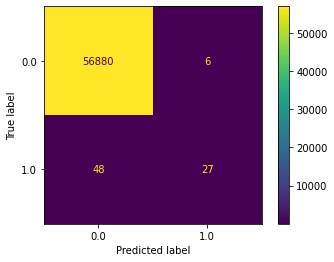

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score

ConfusionMatrixDisplay.from_predictions(test_lbls, test_preds)

accuracy = test_metrics['accuracy']
precision = precision_score(test_lbls, test_preds)
recall = recall_score(test_lbls, test_preds)

print(f'ACCURACY: {accuracy}')
print(f'PRECISION: {precision}')
print(f'RECALL: {recall}')

# Build model with changes to fit data better

- replicate TPs
- implement focal loss instead of regular cross entropy

In [11]:
# Replicate each TP in the training set n times
n = 10 # higher n => higher recall, lower precision

TP_idxs = (train_y == 1).nonzero(as_tuple=True)[0]
print(f'Percentage of TPs in original training data -> {(TP_idxs.shape[0] / train_y.shape[0]) * 100} %')

extra_xs = train_x[TP_idxs].repeat(n, 1)
extra_ys = train_y[TP_idxs].repeat(n,)

train_x_mod = torch.cat((train_x, extra_xs), 0)
train_y_mod = torch.cat((train_y, extra_ys), 0)

print(f'Old shapes: {train_x.shape}, {train_y.shape}')
print(f'New shapes: {train_x_mod.shape}, {train_y_mod.shape}')

Percentage of TPs in original training data -> 0.18301835450260262 %
Old shapes: torch.Size([227846, 3]), torch.Size([227846])
New shapes: torch.Size([232016, 3]), torch.Size([232016])


In [12]:
input_size = (1, 3)
batch_size = 128

train_mod = [train_x_mod, train_y_mod]
train_dset_mod = CustomTensorDataset(train_mod)
train_loader_mod = DataLoader(train_dset_mod, collate_fn=custom_collate_fn, batch_size=batch_size, shuffle=True)

test = [test_x, test_y]
test_dset = CustomTensorDataset(test)
test_loader = DataLoader(test_dset, collate_fn=custom_collate_fn, batch_size=batch_size, shuffle=True)

# optimization - loading the whole dataset into memory
train_features = jnp.array(train_dset_mod.data)
train_lbls = jnp.array(train_dset_mod.targets)

# np.expand_dims is to convert shape from (10000, 28, 28) -> (10000, 28, 28, 1)
# We don't have to do this for training images because custom_transform does it for us.
test_features = jnp.array(test_dset.data)
test_lbls = jnp.array(test_dset.targets)

## Create test loader

for data in train_loader_mod:
  x, y = data
  print(x.shape)
  print(y.shape)
  break

print(test_features.shape)
print(test_lbls.shape)

(128, 3)
(128,)
(56961, 3)
(56961,)


In [13]:
# TRAINING

# Compute loss and update - this will be computed many times, so it's best to jit it
@jit
def training_state(state, imgs, gt_labels):

  def crossEntropy_loss(params, batch_stats):
    logits, updates = NN_regularized().apply({'params': params, 'batch_stats': batch_stats}, imgs, train=True, rngs={'dropout': jax.random.PRNGKey(0)}, mutable=['batch_stats'])
    # logits is a vector of probabilities predicted by the model (the highest value in the vector is the prediction)
    one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=2) # one hot encoded vector of labels
    # logits.shape and one_hot_gt_labels shape is (batch_size, num_classes)
    loss = -jnp.mean(jnp.sum(logits * one_hot_gt_labels, axis=-1)) # axis=-1 means sum over rows ||-> CE = true probability (one hot gt labels) * predicted probability (logits)

    #### TODO 
    # Cross entropy to focal loss -> -log(pt) TO -log(pt) * (1-pt)^(gamma)
    # above is -log(pt), need to find (1-pt)^gamma. log10(x) = 2 ==> x = 10^2, therefore log10(x) = logit ==> x = 10^logit
    gamma = 2
    probs_t = jnp.power(10, logits)
    rev_probs_t = jnp.power(1-probs_t, gamma)
    ####

    return loss, (logits, updates)
  
  (loss, (logits, updates)), grads = jax.value_and_grad(crossEntropy_loss, argnums=0, has_aux=True)(state.params, state.batch_stats)
  state = state.apply_gradients(grads=grads) # update state params based on grads calculated
  state = state.replace(batch_stats=updates['batch_stats']) # update state batch_stats variables

  ## Accuracy
  accuracy = jnp.mean(jnp.argmax(logits, -1) == gt_labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy
  }

  return state, metrics

# One epoch - need to add metrics part
def train_one_epoch(state, dataloader):
  batch_metrics = []
  for cnt, (imgs, labels) in enumerate(dataloader):
    state, metrics = training_state(state, imgs, labels)
    batch_metrics.append(metrics)

  batch_metrics_np = jax.device_get(batch_metrics)  # pull from the accelerator onto host (CPU)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]
  }

  return state, epoch_metrics_np

def create_train_state(key, lr, momentum):
  # Create model
  NN = NN_regularized()
  # Initialize parameters
  variables = NN.init(key, jnp.ones([1, *input_size]), train=False)
  params = variables['params']
  batch_stats_v = variables['batch_stats']
  del variables

  class TrainState_stats(train_state.TrainState):
    batch_stats: Any

  state = TrainState_stats.create(
    apply_fn=NN.apply,
    params=params,
    batch_stats=batch_stats_v,
    tx=optax.sgd(lr, momentum)
  )

  return state

In [14]:
# EVALUATION

# Run one evaluation on test set
@jit
def eval_step(state, imgs, gt_labels):
  logits = NN_regularized().apply({'params': state.params, 'batch_stats': state.batch_stats}, imgs, rngs={'dropout': jax.random.PRNGKey(0)}, train=False)
  one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=2)
  loss = -jnp.mean(jnp.sum(logits * one_hot_gt_labels, axis=-1))
  preds = jnp.argmax(logits, -1)
  accuracy = jnp.mean(preds == gt_labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy
  }
  return metrics, preds

def evaluate_model(state, test_imgs, test_labels):
  metrics, preds = eval_step(state, test_imgs, test_labels)
  metrics = jax.device_get(metrics) # pull from accelerator to CPU
  metrics = jax.tree_map(lambda x: x.item(), metrics) # get scalar value from array
  return metrics, preds

In [15]:
# FIT 2 - replicate TPs + (TODO - focal loss)

from flax.training import train_state
seed = 0
lr = 0.01 # lower learning rate with batch norm
momentum = 0.9
n_epochs = 4

train_state = create_train_state(jax.random.PRNGKey(seed), lr, momentum)

for epoch in range(n_epochs):
  print(f'EPOCH {epoch+1}')

  train_state, train_metrics = train_one_epoch(train_state, train_loader_mod)
  print(f'Train accuracy: {train_metrics["accuracy"]}, Train loss: {train_metrics["loss"]}')

  test_metrics, test_preds = evaluate_model(train_state, test_features, test_lbls)
  print(f'Test accuracy: {test_metrics["accuracy"]}, Test loss: {test_metrics["loss"]}')
  print(' ')

EPOCH 1
Train accuracy: 0.9862236380577087, Train loss: 0.049358904361724854
Test accuracy: 0.9957338571548462, Test loss: 0.030870113521814346
 
EPOCH 2
Train accuracy: 0.9881187677383423, Train loss: 0.043146006762981415
Test accuracy: 0.9988763928413391, Test loss: 0.019584350287914276
 
EPOCH 3
Train accuracy: 0.9882566928863525, Train loss: 0.042162515223026276
Test accuracy: 0.9973490238189697, Test loss: 0.02263578027486801
 
EPOCH 4
Train accuracy: 0.9887332916259766, Train loss: 0.04144949093461037
Test accuracy: 0.9964887499809265, Test loss: 0.023896440863609314
 


ACCURACY: 0.9964887499809265
PRECISION: 0.19806763285024154
RECALL: 0.5466666666666666


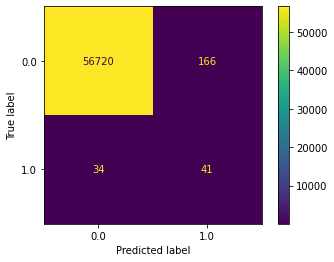

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_lbls, test_preds)

accuracy = test_metrics['accuracy']
precision = precision_score(test_lbls, test_preds)
recall = recall_score(test_lbls, test_preds)

print(f'ACCURACY: {accuracy}')
print(f'PRECISION: {precision}')
print(f'RECALL: {recall}')